[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rbg-research/AI-Training/blob/main/voice-analytics/introduction/Tutorial-3.ipynb)

# Audio Classification - Common Voice Corpus - Gender Prediction

In [ ]:
!pip3 install datasets

In [ ]:
!pip3 install librosa

In [ ]:
!pip3 install matplotlib

In [ ]:
!pip3 install pandas

In [ ]:
!pip3 install sklearn

In [ ]:
!pip3 install tensorflow

### 1. Data Preparation

In [1]:
import datasets
import pandas as pd

In [2]:
# loading train and test data 

dataset = datasets.load_dataset('common_voice', 'ta') # loads tamil corpus

train = dataset["train"] # get the train split

test = dataset["test"] # get the test split


Reusing dataset common_voice (/home/ubuntu/.cache/huggingface/datasets/common_voice/ta/6.1.0/078d412587e9efeb0ae2e574da99c31e18844c496008d53dc5c60f4159ed639b)


  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
# making a dataframe for faster processing
train_files, train_labels = dataset["train"]["path"], dataset["train"]["gender"]
train_df = pd.DataFrame.from_dict({"path": train_files, "label": train_labels})

# filtering the sample that doesn't have the gender class
train_df = train_df[train_df["label"]!=""]
train_df = train_df[train_df["label"]!="others"]
# getting audio files and ground truth labels
train_files, train_labels = list(train_df["path"]), list(train_df["label"])



# repeating same steps to test corpus also
test_files, test_labels = dataset["test"]["path"], dataset["test"]["gender"]
test_df = pd.DataFrame.from_dict({"path": test_files, "label": test_labels})

# filtering the sample that doesn't have the gender class
test_df = test_df[test_df["label"]!=""]
test_df = test_df[test_df["label"]!="other"]
# getting audio files and ground truth labels
test_files, test_labels = list(test_df["path"]), list(test_df["label"])


In [4]:
# number of training samples availble for each class
print("number of train samples per class 'male':", train_labels.count("male"))
print("number of train samples per class 'female':", train_labels.count("female"))

number of train samples per class 'male': 885
number of train samples per class 'female': 770


In [5]:
# number of test samples availble for each class
print("number of test samples per class 'male':", test_labels.count("male"))
print("number of test samples per class 'female':", test_labels.count("female"))

number of test samples per class 'male': 1073
number of test samples per class 'female': 166


### 2. Data Observation and Feature Engineering

In [6]:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML 
# Center matplotlib figures...
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [7]:
import librosa
import librosa.display as display
import IPython.display as ipd
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# getting one demo file per class for observations
male_file = train_files[train_labels.index("male")]
female_file = train_files[train_labels.index("female")]

In [9]:
# loading audio file with specific sampling rate
x_male , sr = librosa.load(male_file, sr=16000)
print(type(x_male), type(sr))

x_female , sr = librosa.load(female_file, sr=16000)
print(type(x_female), type(sr))

<class 'numpy.ndarray'> <class 'int'>
<class 'numpy.ndarray'> <class 'int'>


In [10]:
ipd.Audio(x_male, rate=sr)

In [11]:
ipd.Audio(x_female, rate=sr)

Text(0.5, 1.0, 'Female')

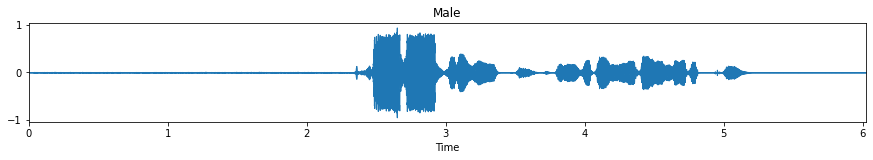

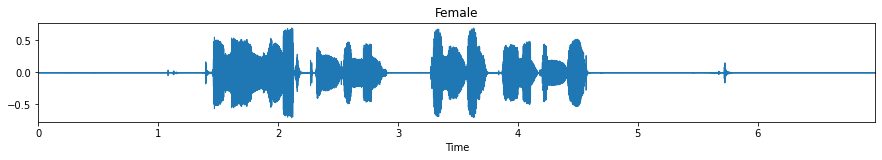

In [12]:
# visualizing audio signals (male & female) in wave (time) domain

plt.figure(figsize=(15,4))
plt.subplot(2, 1, 1)
display.waveplot(x_male, sr=sr)
plt.title('Male')

plt.figure(figsize=(15,4))
plt.subplot(2, 1, 2)
display.waveplot(x_female, sr=sr)
plt.title('Female')

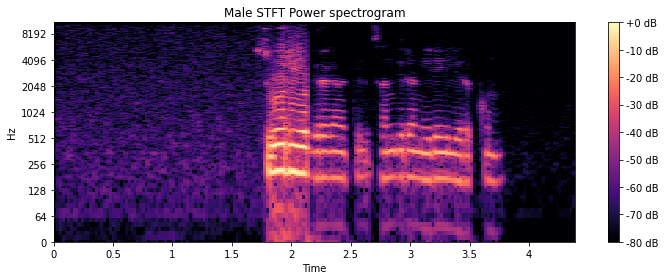

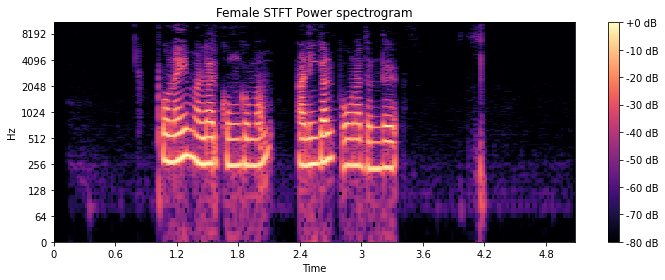

In [13]:
# visualizing the combination of power spectrograms output by STFT w.r.t time

stft_spectrum_matrix = librosa.stft(x_male)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Male STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(x_female)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Female STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

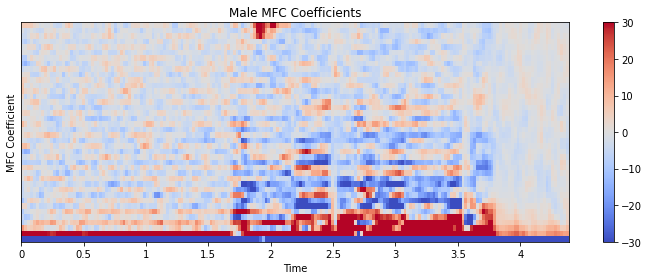

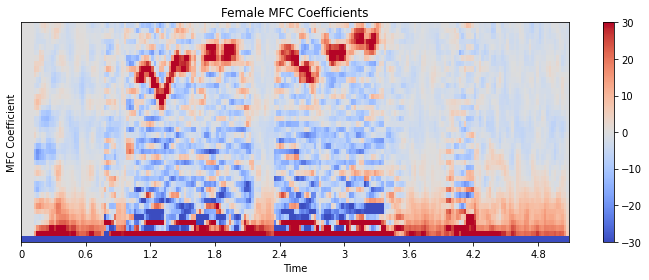

In [14]:

mfc_coefficients = librosa.feature.mfcc(y=x_male, sr=sr, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Male MFC Coefficients')
plt.tight_layout()
                                        
mfc_coefficients = librosa.feature.mfcc(y=x_female, sr=sr, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Female MFC Coefficients')
plt.tight_layout()


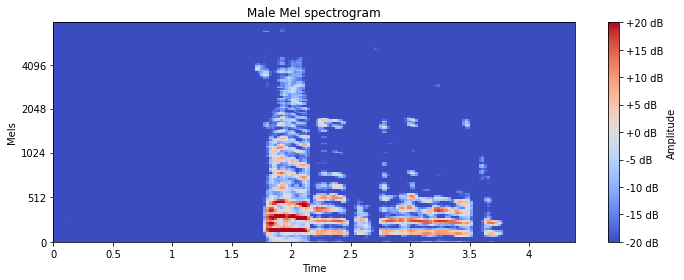

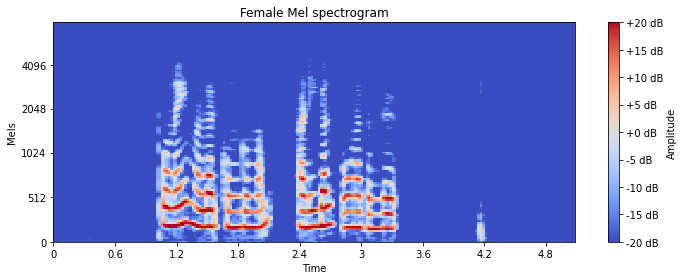

In [15]:
melspectrogram = librosa.feature.melspectrogram(y=x_male, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Male Mel spectrogram')
plt.tight_layout()

melspectrogram = librosa.feature.melspectrogram(y=x_female, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Female Mel spectrogram')
plt.tight_layout()

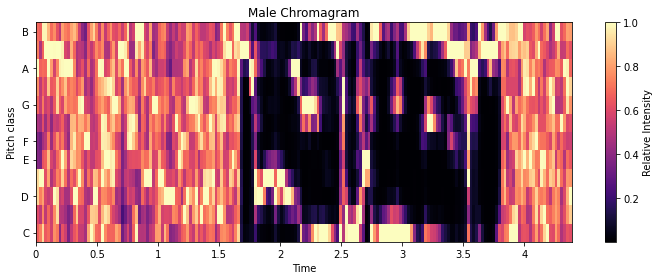

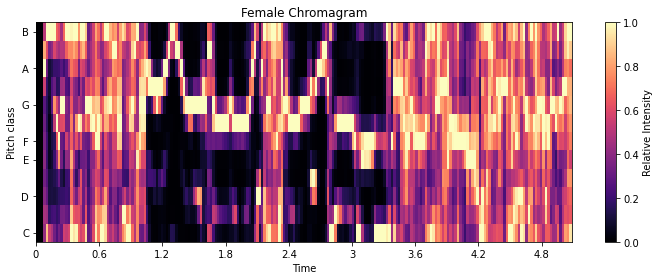

In [16]:
chromagram = librosa.feature.chroma_stft(y=x_male, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Male Chromagram')
plt.tight_layout()

chromagram = librosa.feature.chroma_stft(y=x_female, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Female Chromagram')
plt.tight_layout()

### 3. Feature Extraction

In [17]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

In [18]:
def get_features(file):
    # load an individual soundfile
     
    waveform , sr = librosa.load(file, sr=16000)
    sample_rate = sr
    # compute features of soundfile
    chromagram = feature_chromagram(waveform, sample_rate)
    melspectrogram = feature_melspectrogram(waveform, sample_rate)
    mfc_coefficients = feature_mfcc(waveform, sample_rate)

    feature_matrix=np.array([])
    # use np.hstack to stack our feature arrays horizontally to create a feature matrix
    feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

    return feature_matrix

In [19]:
def get_feature_matrix(files, labels):
    temp_feats = list()
    temp_labels = list()
    for file, label in zip(files, labels):
        features = get_features(file)
        temp_feats.append(features)
        temp_labels.append(label)
    return np.array(temp_feats), np.array(temp_labels)

In [20]:
train_features, train_labels = get_feature_matrix(train_files, train_labels)
test_features, test_labels = get_feature_matrix(test_files, test_labels)

In [21]:
train_features.shape

(1655, 180)

In [22]:
test_features.shape

(1239, 180)

### 4. Feature Scaling

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [24]:
train_df = pd.DataFrame(train_features)
test_df = pd.DataFrame(test_features)

In [25]:
def get_features_statistics(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}') 

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

In [26]:
get_features_statistics(train_df)

12 Chromagram features:           min = 0.256,     max = 0.890,     mean = 0.572,     deviation = 0.091

128 Mel Spectrogram features:     min = 0.000,     max = 445.496,     mean = 3.269,     deviation = 11.391

40 MFCC features:                 min = -551.349,    max = 204.160,    mean = -7.695,    deviation = 56.766


In [27]:
get_features_statistics(test_df)

12 Chromagram features:           min = 0.151,     max = 0.875,     mean = 0.590,     deviation = 0.100

128 Mel Spectrogram features:     min = 0.000,     max = 815.608,     mean = 3.254,     deviation = 15.877

40 MFCC features:                 min = -612.689,    max = 170.051,    mean = -8.079,    deviation = 58.956


In [28]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

scaler = MinMaxScaler()
train_features_minmax = scaler.fit_transform(train_features)


scaler = StandardScaler()
test_features_scaled = scaler.fit_transform(test_features)

scaler = MinMaxScaler()
test_features_minmax = scaler.fit_transform(test_features)


In [29]:
print("Train Standard Scaling:")
print(" ".join(["-"]*15))
train_features_scaled_df = pd.DataFrame(train_features_scaled)
get_features_statistics(train_features_scaled_df)
print("\n\n")

print('Train MinMax Scaling:')
print(" ".join(["-"]*15))
trainfeatures_minmax_df = pd.DataFrame(train_features_minmax)
get_features_statistics(trainfeatures_minmax_df)
print("\n\n")

print("Test Standard Scaling:")
print(" ".join(["-"]*15))
test_features_scaled_df = pd.DataFrame(test_features_scaled)
get_features_statistics(test_features_scaled_df)
print("\n\n")

print('Test MinMax Scaling:')
print(" ".join(["-"]*15))
test_features_minmax_df = pd.DataFrame(test_features_minmax)
get_features_statistics(test_features_minmax_df)

Train Standard Scaling:
- - - - - - - - - - - - - - -
12 Chromagram features:           min = -4.198,     max = 3.538,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -1.217,     max = 39.958,     mean = -0.000,     deviation = 1.000

40 MFCC features:                 min = -8.483,    max = 6.466,    mean = 0.000,    deviation = 1.000



Train MinMax Scaling:
- - - - - - - - - - - - - - -
12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.524,     deviation = 0.168

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.034,     deviation = 0.075

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.449,    deviation = 0.165



Test Standard Scaling:
- - - - - - - - - - - - - - -
12 Chromagram features:           min = -4.437,     max = 2.953,     mean = -0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.790,     max = 33.357,     mean = 0.000,     deviation = 1

### 5. Feature Observation and Elimination

In [30]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
encoder = LabelEncoder()
encoder.fit((train_labels.tolist() + test_labels.tolist()))

encoded_train_labels = encoder.transform(train_labels)
encoded_test_labels = encoder.transform(test_labels)

In [32]:
train_df.shape

(1655, 180)

In [33]:
train_df[180] = encoded_train_labels

In [34]:
train_df.shape

(1655, 181)

In [35]:
corr = train_df.corr()
class_correlation = list(corr[180])
feature_indexes = list(range(181))
sorted_feature_indexes = [x for _,x in sorted(zip(class_correlation, feature_indexes))]
feature_selection = sorted_feature_indexes[:10] + sorted_feature_indexes[171:]

In [36]:
corr

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,1.000000,0.863295,0.697257,0.610488,0.540184,0.390091,0.244336,0.215444,0.336067,0.412633,...,-0.623191,-0.627912,-0.550625,-0.507546,-0.394435,-0.409757,-0.414008,-0.332822,-0.183625,0.606901
1,0.863295,1.000000,0.852900,0.672720,0.570829,0.438638,0.382914,0.295506,0.339470,0.380425,...,-0.570595,-0.538219,-0.439273,-0.465606,-0.414448,-0.522605,-0.435949,-0.269116,-0.061448,0.642460
2,0.697257,0.852900,1.000000,0.876748,0.701212,0.450815,0.313926,0.279895,0.357149,0.437306,...,-0.506933,-0.524213,-0.469648,-0.523996,-0.427087,-0.420093,-0.278699,-0.079423,0.083425,0.689033
3,0.610488,0.672720,0.876748,1.000000,0.876256,0.539439,0.272294,0.184784,0.373958,0.506061,...,-0.523724,-0.555311,-0.496653,-0.478743,-0.320153,-0.280833,-0.136464,0.075868,0.179996,0.684329
4,0.540184,0.570829,0.701212,0.876256,1.000000,0.768544,0.400753,0.200374,0.332738,0.510586,...,-0.501716,-0.451956,-0.340839,-0.275367,-0.119634,-0.098109,0.018791,0.181537,0.151243,0.582829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,-0.409757,-0.522605,-0.420093,-0.280833,-0.098109,0.105576,-0.097053,-0.224159,-0.270763,-0.281572,...,0.363646,0.425245,0.451743,0.628961,0.706166,1.000000,0.661789,0.468650,0.171976,-0.445509
177,-0.414008,-0.435949,-0.278699,-0.136464,0.018791,0.060763,-0.148884,-0.226865,-0.275373,-0.213264,...,0.321620,0.349542,0.404151,0.425177,0.584524,0.661789,1.000000,0.655554,0.497912,-0.280708
178,-0.332822,-0.269116,-0.079423,0.075868,0.181537,0.118767,-0.024565,-0.189676,-0.317632,-0.147581,...,0.170867,0.278296,0.351821,0.366045,0.364186,0.468650,0.655554,1.000000,0.627189,-0.078888
179,-0.183625,-0.061448,0.083425,0.179996,0.151243,0.013977,-0.096450,-0.300106,-0.333188,-0.139057,...,-0.027968,-0.001164,0.156774,0.154182,0.257785,0.171976,0.497912,0.627189,1.000000,0.102825


In [37]:
temp_train_df = train_df[feature_selection]

In [38]:
temp_train_df.shape

(1655, 20)

In [39]:
corr = temp_train_df.corr()

<AxesSubplot:>

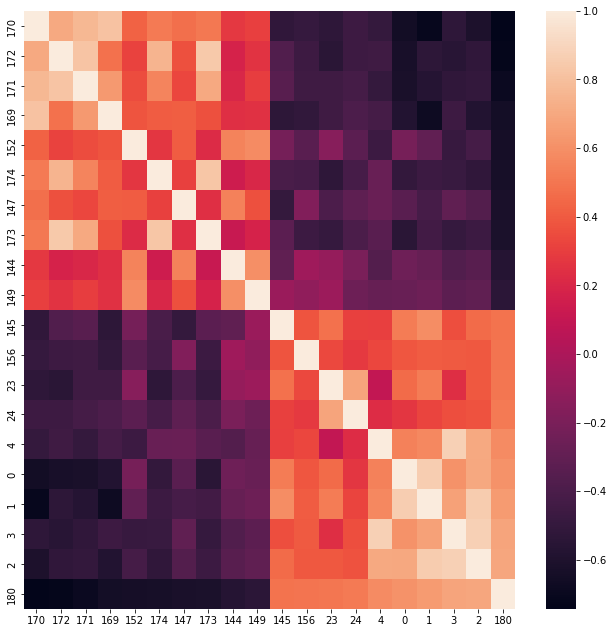

In [40]:
f, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           ax=ax)

In [41]:
train_features_scaled_df[180] = encoded_train_labels
corr = train_features_scaled_df.corr()
class_correlation = list(corr[180])
feature_indexes = list(range(181))
sorted_feature_indexes = [x for _,x in sorted(zip(class_correlation, feature_indexes))]
feature_selection = sorted_feature_indexes[:10] + sorted_feature_indexes[171:]

<AxesSubplot:>

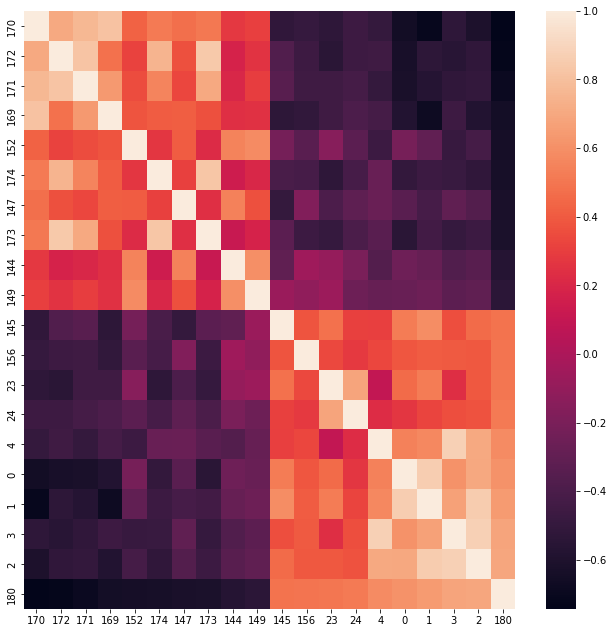

In [42]:
temp_train_df = train_features_scaled_df[feature_selection]
corr = temp_train_df.corr()
f, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           ax=ax)

In [43]:
trainfeatures_minmax_df[180] = encoded_train_labels
corr = trainfeatures_minmax_df.corr()
class_correlation = list(corr[180])
feature_indexes = list(range(181))
sorted_feature_indexes = [x for _,x in sorted(zip(class_correlation, feature_indexes))]
feature_selection = sorted_feature_indexes[:10] + sorted_feature_indexes[171:]

<AxesSubplot:>

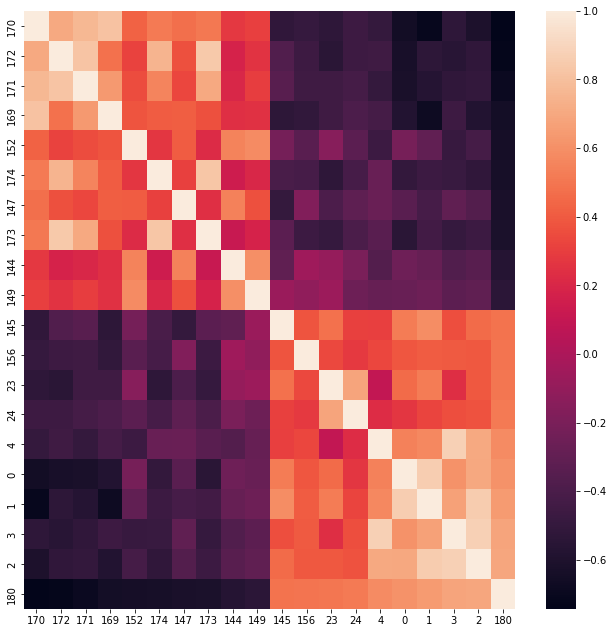

In [44]:
temp_train_df = trainfeatures_minmax_df[feature_selection]
corr = temp_train_df.corr()
f, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           ax=ax)

### 6. Train, Validation and Test

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
############# Unscaled test/train set #############
X_train, X_test, y_train, y_test = train_test_split(
    train_features, 
    encoded_train_labels, 
    test_size=0.2, 
    random_state=69
)



In [47]:
############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    train_features_scaled, 
    encoded_train_labels, 
    test_size=0.2, 
    random_state=69
)



In [48]:
############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    train_features_minmax, 
    encoded_train_labels, 
    test_size=0.2, 
    random_state=69
)

In [49]:
test_features = test_features
test_features_scaled = test_features_scaled
test_features_minmax = test_features_minmax
encoded_test_labels = encoded_test_labels

### 7. Model Selection

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [51]:
classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    LogisticRegression()]

In [52]:
scores = []
for model in classification_models:
    model = model
    model.fit(X_train, y_train)
    score_normal = model.score(X_test, y_test)
    test_normal = model.score(test_features, encoded_test_labels)
    
    model.fit(X_train_scaled, y_train)
    score_scaled = model.score(X_test_scaled, y_test)
    test_scaled = model.score(test_features_scaled, encoded_test_labels)
    
    model.fit(X_train_minmax, y_train)
    score_minmax = model.score(X_test_minmax, y_test)
    test_minmax = model.score(test_features_minmax, encoded_test_labels)
    
    
    
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score_normal:.2f}%'), (f'{100*score_scaled:.2f}%'), (f'{100*score_minmax:.2f}%'),
                  (f'{100*test_normal:.2f}%'), (f'{100*test_scaled:.2f}%'), (f'{100*test_minmax:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Normal', 'Accuracy Scaled', 'Accuracy MinMax',
                                        "Test Normal", "Test Scaled", "Test MinMax"])

In [53]:
scores_df

,Classifier,Accuracy Normal,Accuracy Scaled,Accuracy MinMax,Test Normal,Test Scaled,Test MinMax
0,KNeighborsClassifier,98.49%,99.40%,99.40%,74.25%,57.63%,55.04%
1,SVC,100.00%,99.70%,100.00%,67.88%,54.08%,54.80%
2,SVC RBF kernel,99.40%,97.89%,100.00%,62.79%,51.49%,55.69%
3,DecisionTreeClassifier,96.68%,96.37%,96.37%,73.04%,53.11%,57.22%
4,RandomForestClassifier,99.09%,99.40%,99.70%,72.56%,79.02%,60.29%
5,LogisticRegression,100.00%,100.00%,99.70%,66.02%,54.96%,53.43%


### 8. Model Observation

In [54]:
from sklearn.model_selection import KFold

In [55]:
kf = KFold(n_splits=10)

In [56]:
model = DecisionTreeClassifier()

In [57]:
for train_index, test_index in kf.split(train_features):
    X_train, X_test = train_features[train_index], train_features[test_index]
    y_train, y_test = encoded_train_labels[train_index], encoded_train_labels[test_index]
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))

0.9879518072289156
0.9819277108433735
0.9518072289156626
0.9698795180722891
0.9397590361445783
0.9515151515151515
0.9393939393939394
0.9575757575757575
0.9757575757575757
0.8848484848484849


### 9. Result Observation

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [59]:
test_predictions = model.predict(test_features)
test_groundtruth = encoded_test_labels

In [60]:
conf_matrix = confusion_matrix(test_groundtruth, test_predictions)
conf_matrix_norm = confusion_matrix(test_groundtruth, test_predictions,normalize='true')

In [61]:
np.unique(encoded_test_labels)

array([0, 1])

In [62]:
class_list =["male", "female"]
class_name = [cls for cls in class_list]

In [63]:
confmatrix_df = pd.DataFrame(conf_matrix, index=class_name, columns=class_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=class_name, columns=class_name)

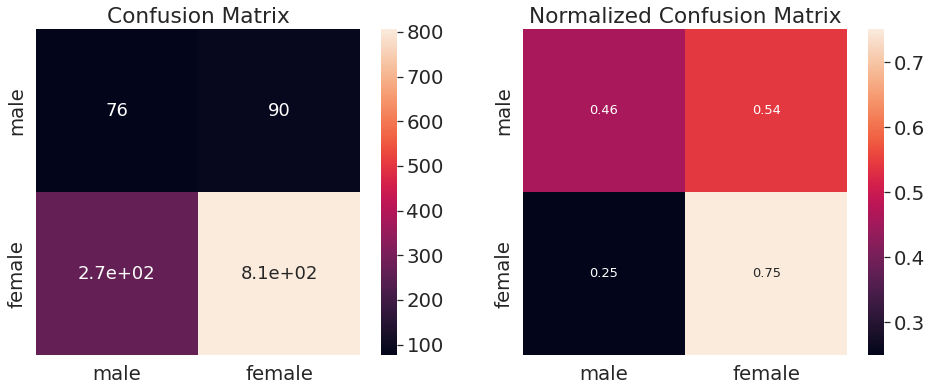

In [64]:
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

In [65]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(test_features)
y_test = encoded_test_labels
print(f'Test Set Accuracy score =  {100*accuracy_score(y_test, y_pred):.3f}%') #same as model.score(X_test, y_test)
print(f'Test Set Precision score =  {100*precision_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_test, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  71.186%
Test Set Precision score =  56.056%
Test Set Recall score =  60.450%
Test Set F-score score =  55.9%


### 10. Time and Model Complexity

In [66]:
import time

In [67]:
train_df.shape

(1655, 181)

In [68]:
train_features_scaled_df[180] = encoded_train_labels
corr = train_features_scaled_df.corr()
class_correlation = list(corr[180])
feature_indexes = list(range(181))
sorted_feature_indexes = [x for _,x in sorted(zip(class_correlation, feature_indexes))]
feature_selection = sorted_feature_indexes[:10] + sorted_feature_indexes[171:]

In [69]:
feature_selection.remove(180)

In [70]:
len(feature_selection)

19

In [71]:
feature_selection

[170,
 172,
 171,
 169,
 152,
 174,
 147,
 173,
 144,
 149,
 145,
 156,
 23,
 24,
 4,
 0,
 1,
 3,
 2]

In [72]:
new_train_df = train_df[feature_selection]

In [73]:
new_train_df.shape

(1655, 19)

In [74]:
new_training_features = new_train_df.to_numpy()

In [75]:
model = DecisionTreeClassifier()

In [76]:
for train_index, test_index in kf.split(new_training_features):
    X_train, X_test = train_features[train_index], train_features[test_index]
    y_train, y_test = encoded_train_labels[train_index], encoded_train_labels[test_index]
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))

0.9879518072289156
0.9939759036144579
0.9518072289156626
0.9698795180722891
0.9397590361445783
0.9454545454545454
0.9393939393939394
0.9757575757575757
0.9696969696969697
0.8363636363636363


In [77]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(test_features)
y_test = encoded_test_labels
print(f'Test Set Accuracy score =  {100*accuracy_score(y_test, y_pred):.3f}%') #same as model.score(X_test, y_test)
print(f'Test Set Precision score =  {100*precision_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_test, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  70.621%
Test Set Precision score =  55.542%
Test Set Recall score =  59.614%
Test Set F-score score =  55.2%


In [78]:
start = time.time()
model.fit(train_features, encoded_train_labels)
end = time.time()
print("model train time with the complete features", end - start)

model train time with the complete features 0.2180025577545166


In [79]:
start = time.time()
model.fit(new_training_features, encoded_train_labels)
end = time.time()
print("model train time with the selected features", end - start)

model train time with the selected features 0.02660536766052246
